# Predicting Lifetime Video Performance from Early Engagement

This project explores how early engagement signals (e.g. views, likes, comments, impressions) can help predict a video’s lifetime performance — using a simplified approach.

## Business Goal
Given early video engagement data (up to 5,000 impressions), predict **total lifetime views** to guide:
- Marketing and platform teams often need to know **early** which videos are likely to succeed.
- Predicting long-term view growth helps in **budget allocation**, **resharing strategy**, and **content prioritization**.
- The modeling approach balances **predictive accuracy**, **interpretability**, and **business application**.

The notebook showcases a **full data-to-insight pipeline** that is business-aware — intended for data practitioners, content strategists, and decision-makers evaluating video performance.

In [12]:
# Core data and modeling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict

sns.set(style="whitegrid")

## Step 1: Load and Prepare Dataset

We start by loading a synthetic video engagement dataset that simulates real platform data. Since we are modeling business-relevant performance, we apply a minimum final view threshold (1,000 views) to focus on meaningful samples.

In [13]:
# Load dataset
df = pd.read_csv("../data/Video_Timeseries_synthetic_Dataset.csv").dropna().reset_index(drop=True)
print(f"Original dataset shape: {df.shape}")

# Filter: meaningful content only (views ≥ 1000)
df = df[df['views_final'] >= 1000].reset_index(drop=True)
print(f"Dataset shape after filtering (views_final >= 1000): {df.shape}")

Original dataset shape: (7639, 9)
Dataset shape after filtering (views_final >= 1000): (5100, 9)


The dataset includes early engagement data up to 5,000 impressions, and a final view count which serves as our target variable. Model trained on 5,100 videos with ≥1,000 final views.

We now take a quick look at key dataset statistics.

In [14]:
# View dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   views_final     5100 non-null   int64
 1   views3s_1k      5100 non-null   int64
 2   impressions_1k  5100 non-null   int64
 3   like_1k         5100 non-null   int64
 4   comments_1k     5100 non-null   int64
 5   views3s_5k      5100 non-null   int64
 6   impressions_5k  5100 non-null   int64
 7   like_5k         5100 non-null   int64
 8   comments_5k     5100 non-null   int64
dtypes: int64(9)
memory usage: 358.7 KB


## Step 2: Target Variable Distribution: Understanding Final Views

Before modeling, it's important to understand the range and skew of our target variable (`views_final`):

- Most videos perform modestly.
- A small number reach viral scale.
- This extreme skew makes modeling challenging.

Below are the key percentiles and summary stats:

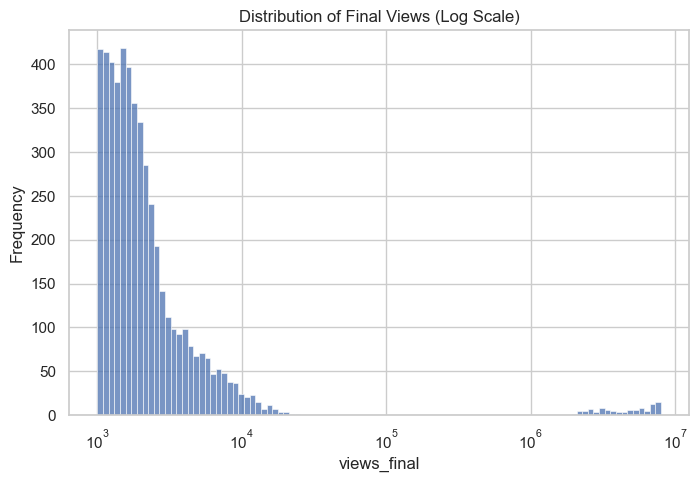

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df['views_final'], bins=100, log_scale=True)
plt.title("Distribution of Final Views (Log Scale)")
plt.xlabel("views_final")
plt.ylabel("Frequency")
plt.show()

## Step 3: Normalize Metrics and Engineer Ratios

Raw engagement counts (likes, views, comments) are hard to compare across videos with different impressions. We normalize them relative to impressions and views to get metrics like:

- Open rate: How likely viewers are to watch (views / impressions)
- Engagement rate: How likely viewers are to like (likes / views)
- Comment ratio: How active the viewers are (comments / likes)

These tell us more about how audiences interact with content relative to exposure.

In [16]:
# Normalize key engagement metrics
df['norm_views3s_1k'] = df['views3s_1k'] / 1000
df['norm_like_1k'] = df['like_1k'] / 1000
df['norm_comments_1k'] = df['comments_1k'] / 1000
df['norm_views3s_5k'] = df['views3s_5k'] / 5000
df['norm_like_5k'] = df['like_5k'] / 5000
df['norm_comments_5k'] = df['comments_5k'] / 5000

# Engineer engagement ratios
epsilon = 1e-5
df['openrate3s_1k'] = df['views3s_1k'] / (df['impressions_1k'] + epsilon)
df['openrate3s_5k'] = df['views3s_5k'] / (df['impressions_5k'] + epsilon)
df['engrate_1k'] = df['like_1k'] / (df['views3s_1k'] + epsilon)
df['engrate_5k'] = df['like_5k'] / (df['views3s_5k'] + epsilon)
df['commentratio_1k'] = df['comments_1k'] / (df['like_1k'] + epsilon)
df['commentratio_5k'] = df['comments_5k'] / (df['like_5k'] + epsilon)

## Step 4: Feature Preparation for Modeling

To ensure robustness against outliers and uneven scales, we scale all features using `RobustScaler`. This is especially suited to engagement data, which can be skewed.

We also prepare a modeling-ready feature matrix and define our target: `views_final`.

In [17]:
# Combine selected features
combined_features = [
    'norm_views3s_1k', 'norm_like_1k', 'norm_comments_1k',
    'norm_views3s_5k', 'norm_like_5k', 'norm_comments_5k',
    'openrate3s_1k', 'openrate3s_5k',
    'engrate_1k', 'engrate_5k',
    'commentratio_1k', 'commentratio_5k'
]

X = df[combined_features]
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Target: log-transformed views_final
df['log_views_final'] = np.log1p(df['views_final'])
y = df['log_views_final']

## Step 5: Model Evaluation

We compare three model types using 3-fold cross-validation:
- `LinearRegression` as a baseline
- `RandomForestRegressor` for non-linear modeling
- `XGBRegressor` for gradient-boosted performance

We use **mean absolute error (MAE)** and **mean absolute percentage error (MAPE)** as business-relevant metrics — they directly reflect how much we over/underpredict video performance in terms of views.

In [18]:
results = []

models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForest', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=50, objective='reg:squarederror', random_state=42))
]

for name, model in models:
    pipeline = Pipeline([('model', model)])

    # Predict via cross-validation (no leakage)
    y_pred_log = cross_val_predict(pipeline, X_scaled, y, cv=3)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(df['views_final'], y_pred)
    mape = mean_absolute_percentage_error(df['views_final'], y_pred) * 100

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2)
    })

# Display as DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,Model,MAE,MAPE (%)
0,LinearRegression,96944.33,43.95
1,RandomForest,96672.25,36.77
2,XGBoost,96707.29,38.34


## Final Thoughts

We built a model to predict lifetime video performance using only early engagement metrics from the first 5,000 impressions.

With this limited feature set, the Random Forest model achieved:
- MAE ≈ 96K
- MAPE ≈ 36% (3-fold CV)

### What Could Improve the Model

To reduce error further, the following types of data would be helpful:
- Video metadata (duration, format)
- Content signals (category, keywords, thumbnail quality)
- Audience info (watch time, demographics)
- Creator history (past video stats, audience size)
- Timing/context (day, hour, promotion status)

### Business Applications

This model can support:
- Early video prioritization
- Smarter promotion and reshare decisions
- Creator content analysis

Even with minimal input, the model offers directional guidance for content and marketing teams